# Homework: Online Statistics and Regressions
Robert Hatem

## Online Algorithms in Performing statistics and regressions

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from fred import Fred
import time
import datetime
%matplotlib inline

In [68]:
df_BTC_USD = pd.read_csv('sparse_narrow_BTC-USD.delim', sep='|')
df_ETH_BTC = pd.read_csv('sparse_narrow_ETH-BTC.delim', sep='|')
df_ETH_USD = pd.read_csv('sparse_narrow_ETH-USD.delim', sep='|')

df_BTC_USD.Mid = df_BTC_USD.Mid * 1e-6
df_ETH_BTC.Mid = df_ETH_BTC.Mid * 1e-6
df_ETH_USD.Mid = df_ETH_USD.Mid * 1e-6

## EWMA

In [71]:
# BTC-USD
def calc_ewma(df, tau=3e11, calc_returns=False):
    df_temp = df.copy()
    lamb=1/tau
    
    constant_time = 1-np.exp(-lamb*df_temp['received_utc_nanoseconds'].diff())
    constant_count = 1-0.99  # discount for count based EWMA ??

    df_temp = df_temp.assign(constant=constant_time)
    df_temp = df_temp.assign(ewma_t=df_temp.at[0,'Mid'])
    df_temp = df_temp.assign(ewma_c=df_temp.at[0,'Mid'])
    
    t0 = time.time()
    for i, row in df_temp.iterrows():
        if i==0:
            continue
        if i%round(df_temp.shape[0]/100)==0:
            time_left = round( ((t.time()-t0)/i)*(df_temp.shape[0]-i)/60 ,2)
            print('Finished {} of {}'.format(i, df_temp.shape[0]), '| Estimated time in this loop: {} mins'.format(time_left)) 
        else:
            df_temp.at[i,'ewma_t'] = row['constant']*df_temp.at[i-1,'ewma_t'] + (1-row['constant'])*row['Mid']
            df_temp.at[i,'ewma_c'] = constant_count*df_temp.at[i-1,'ewma_c'] + (1-constant_count)*row['Mid']
    
    df_temp = df_temp.assign(ret_t = np.log(df_temp['Mid']/df_temp['ewma_t'].shift(1)))
    df_temp = df_temp.assign(ret_c = np.log(df_temp['Mid']/df_temp['ewma_c'].shift(1)))
    
    if calc_returns:
        print('stoppp!!!')        
        df_temp = df_temp.assign(mu_time=np.nan)  
        df_temp = df_temp.assign(mu_count=np.nan)

        t0 = time.time()
        for i, row in df_temp.iterrows():
            if i==0:
                next
            if i%round(df_temp.shape[0]/100)==0:
                time_left = round( ((t.time()-t0)/(i+1))*(df_temp.shape[0]-i)/60 ,2)
                print('Finished {} of {}'.format(i, df_temp.shape[0]), '| Estimated time in this loop: {} mins'.format(time_left)) 
            elif i==1:
                df_temp.at[i,'mu_time'] = df_temp.at[i, 'ret_t']
                df_temp.at[i,'mu_count'] = df_temp.at[i, 'ret_c']
            elif i==2:
                df_temp.at[i,'mu_time'] = df_temp.at[i-1, 'mu_time'] + (1 - df_temp.at[i,'constant']) * (df_temp.at[i,'ret_t'] - df_temp.at[i-1,'mu_time'])
                df_temp.at[i,'mu_count'] = df_temp.at[i-1, 'mu_count'] + (1 - df_temp.at[i,'constant']) * (df_temp.at[i,'ret_c'] - df_temp.at[i-1,'mu_count'])

                df_temp.at[i, 'sigma_time'] = np.var([ df_temp.at[i,'ret_t'], df_temp.at[i-1, 'ret_t']])
                df_temp.at[i, 'sigma_count'] = np.var([ df_temp.at[i,'ret_c'], df_temp.at[i-1, 'ret_c']])
            else:
                df_temp.at[i,'mu_time'] = df_temp.at[i-1,'mu_time'] + (1 - df_temp.at[i,'constant']) * (df_temp.at[i,'ret_t'] - df_temp.at[i-1,'mu_time'])
                df_temp.at[i,'mu_count'] = df_temp.at[i-1,'mu_count'] + (1 - df_temp.at[i,'constant']) * (df_temp.at[i,'ret_c'] - df_temp.at[i-1,'mu_count'])

                df_temp.at[i,'sigma_time'] = df_temp.at[i,'constant']*(df_temp.at[i-1,'sigma_time'] + (df_temp.at[i,'ret_t']- df_temp.at[i-1,'mu_time'])*(1-df_temp.at[i,'constant'])*(df_temp.at[i,'ret_t']- df_temp.at[i-1,'mu_time']))
                df_temp.at[i,'sigma_count'] = constant_count*(df_temp.at[i-1,'sigma_count'] + (df_temp.at[i,'ret_c']- df_temp.at[i-1,'mu_time'])*(1-constant_count)*(df_temp.at[i,'ret_t']- df_temp.at[i-1,'mu_time']))

    return df_temp

In [72]:
# run EWMAs
df_BTC_USD_1 = calc_ewma(df_BTC_USD, calc_returns=True)
df_ETH_BTC_1 = calc_ewma(df_ETH_BTC, calc_returns=True)
df_ETH_USD_1 = calc_ewma(df_ETH_USD, calc_returns=True)

Finished 10000 of 1000001 | Estimated time in this loop: 4.83 mins
Finished 20000 of 1000001 | Estimated time in this loop: 4.62 mins
Finished 30000 of 1000001 | Estimated time in this loop: 4.5 mins
Finished 40000 of 1000001 | Estimated time in this loop: 4.88 mins
Finished 50000 of 1000001 | Estimated time in this loop: 5.01 mins
Finished 60000 of 1000001 | Estimated time in this loop: 5.27 mins
Finished 70000 of 1000001 | Estimated time in this loop: 5.25 mins
Finished 80000 of 1000001 | Estimated time in this loop: 5.23 mins
Finished 90000 of 1000001 | Estimated time in this loop: 5.2 mins
Finished 100000 of 1000001 | Estimated time in this loop: 5.16 mins
Finished 110000 of 1000001 | Estimated time in this loop: 5.13 mins
Finished 120000 of 1000001 | Estimated time in this loop: 5.08 mins
Finished 130000 of 1000001 | Estimated time in this loop: 5.06 mins
Finished 140000 of 1000001 | Estimated time in this loop: 5.0 mins
Finished 150000 of 1000001 | Estimated time in this loop: 4.

In [73]:
df_ETH_BTC_1.head()

,received_utc_nanoseconds,Bid1PriceMillionths,Ask1PriceMillionths,Mid,constant,ewma_t,ewma_c,ret_t,ret_c,mu_time,mu_count,sigma_time,sigma_count
0,1553997385593070000,34390,34460,0.034425,NaN,0.034425,0.034425,NaN,NaN,NaN,NaN,NaN,NaN
1,1553997385594325000,34380,34460,0.034420,0.000004,0.034420,0.034420,-0.000145,-0.000145,-0.000145,-0.000145,NaN,NaN
2,1554032719803226000,34540,34620,0.034580,1.000000,0.034420,0.034578,0.004638,0.004636,-0.000145,-0.000145,0.000006,5.715663e-06
3,1554036415308724900,34460,34530,0.034495,0.999996,0.034420,0.034496,0.002177,-0.002415,-0.000145,-0.000145,0.000006,4.987288e-09
4,1554036777139184200,34490,34560,0.034525,0.700638,0.034451,0.034525,0.003046,0.000845,0.000810,0.000151,0.000006,3.133824e-08


In [74]:
print(df_BTC_USD_1.shape)
print(df_ETH_BTC_1.shape)
print(df_ETH_USD_1.shape)

(1000001, 13)
(3493, 13)
(112864, 13)


In [75]:
print(datetime.datetime.now())

2019-05-08 10:00:10.641974


In [76]:
# reset index
df_BTC_USD_2 = df_BTC_USD_1.set_index('received_utc_nanoseconds')
df_ETH_BTC_2 = df_ETH_BTC_1.set_index('received_utc_nanoseconds')
df_ETH_USD_2 = df_ETH_USD_1.set_index('received_utc_nanoseconds')

# rename columns
df_BTC_USD_2.columns = df_BTC_USD_2.columns.map(lambda x: str(x) + '_BTC_USD')
df_ETH_BTC_2.columns = df_ETH_BTC_2.columns.map(lambda x: str(x) + '_ETH_BTC')
df_ETH_USD_2.columns = df_ETH_USD_2.columns.map(lambda x: str(x) + '_ETH_USD')


# join currencies
df1 = pd.merge(df_BTC_USD_2, df_ETH_BTC_2, left_index=True, right_index=True, how='outer')
df1 = pd.merge(df1, df_ETH_USD_2, left_index=True, right_index=True, how='outer')

In [77]:
df1.isna().sum()

Bid1PriceMillionths_BTC_USD     116357
Ask1PriceMillionths_BTC_USD     116357
Mid_BTC_USD                     116357
constant_BTC_USD                116358
ewma_t_BTC_USD                  116357
ewma_c_BTC_USD                  116357
ret_t_BTC_USD                   116358
ret_c_BTC_USD                   116358
mu_time_BTC_USD                1106359
mu_count_BTC_USD               1106359
sigma_time_BTC_USD             1106360
sigma_count_BTC_USD            1106360
Bid1PriceMillionths_ETH_BTC    1112865
Ask1PriceMillionths_ETH_BTC    1112865
Mid_ETH_BTC                    1112865
constant_ETH_BTC               1112866
ewma_t_ETH_BTC                 1112865
ewma_c_ETH_BTC                 1112865
ret_t_ETH_BTC                  1112866
ret_c_ETH_BTC                  1112866
mu_time_ETH_BTC                1116324
mu_count_ETH_BTC               1116324
sigma_time_ETH_BTC             1116325
sigma_count_ETH_BTC            1116325
Bid1PriceMillionths_ETH_USD    1003494
Ask1PriceMillionths_ETH_U

In [78]:
df1 = df1.fillna(method='ffill')

In [79]:
df1.shape

(1116358, 36)

In [80]:
cols = df1.columns.tolist()
cols1 = [#'Mid_BTC_USD',
# 'constant_BTC_USD',
 'ewma_t_BTC_USD',
 'ewma_c_BTC_USD',
 'ret_t_BTC_USD',
 'ret_c_BTC_USD',
# 'Mid_ETH_BTC',
# 'constant_ETH_BTC',
 'ewma_t_ETH_BTC',
 'ewma_c_ETH_BTC',
 'ret_t_ETH_BTC',
 'ret_c_ETH_BTC',
# 'Mid_ETH_USD',
# 'constant_ETH_USD',
 'ewma_t_ETH_USD',
 'ewma_c_ETH_USD',
 'ret_t_ETH_USD',
 'ret_c_ETH_USD']

In [81]:
df1[cols1].head()

,ewma_t_BTC_USD,ewma_c_BTC_USD,ret_t_BTC_USD,ret_c_BTC_USD,ewma_t_ETH_BTC,ewma_c_ETH_BTC,ret_t_ETH_BTC,ret_c_ETH_BTC,ewma_t_ETH_USD,ewma_c_ETH_USD,ret_t_ETH_USD,ret_c_ETH_USD
received_utc_nanoseconds,,,,,,,,,,,,
1553947362996428000,4084.240000,4084.240000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1553947369683569000,4084.235110,4084.235050,-0.000001,-0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1553947383635764000,4084.263642,4084.264700,0.000007,0.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1553947386959358000,4084.269930,4084.269947,0.000002,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1553947395403787000,4084.722092,4084.730349,0.000114,0.000114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
#df2 = df1[cols1].dropna()
df2 = df1.dropna()
df2.shape

(1106159, 36)

In [99]:
df2.head()

,Bid1PriceMillionths_BTC_USD,Ask1PriceMillionths_BTC_USD,Mid_BTC_USD,constant_BTC_USD,ewma_t_BTC_USD,ewma_c_BTC_USD,ret_t_BTC_USD,ret_c_BTC_USD,mu_time_BTC_USD,mu_count_BTC_USD,...,Mid_ETH_USD,constant_ETH_USD,ewma_t_ETH_USD,ewma_c_ETH_USD,ret_t_ETH_USD,ret_c_ETH_USD,mu_time_ETH_USD,mu_count_ETH_USD,sigma_time_ETH_USD,sigma_count_ETH_USD
received_utc_nanoseconds,,,,,,,,,,,,,,,,,,,,,
1554032719803226000,4.096200e+09,4.096700e+09,4096.450,0.000010,4096.450000,4096.450075,-0.000002,-0.000002,0.000161,0.000148,...,141.83,0.999999,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07
1554033178223252000,4.096200e+09,4.097210e+09,4096.705,0.930742,4096.467661,4096.702451,0.000062,0.000062,0.000161,0.000148,...,141.83,0.999999,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07
1554033250630715000,4.097200e+09,4.097810e+09,4097.505,0.214440,4097.282553,4097.496975,0.000253,0.000196,0.000161,0.000148,...,141.83,0.999999,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07
1554033265172210000,4.097800e+09,4.098210e+09,4098.005,0.047316,4097.970817,4097.999920,0.000176,0.000124,0.000161,0.000148,...,141.83,0.999999,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07
1554033285615970100,4.098200e+09,4.098500e+09,4098.350,0.065876,4098.325021,4098.346499,0.000093,0.000085,0.000161,0.000148,...,141.83,0.999999,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07


In [100]:
#df2.to_csv()
#df2 = pd.read_csv('df2.csv')

In [101]:
tau = 3e11
lamb=1/tau 
c = 0.99
weights_t = np.exp(-lamb*(df2.index.values[-1] - df2.index.values))
weights_c = np.flip(c**np.arange(df2.shape[0]))

weights_t = weights_t/weights_t.sum()
weights_c = weights_c/weights_c.sum()

df3 = df2.assign(weights_t=weights_t).assign(weights_c=weights_c)

df3 = df3.dropna()
df3 = df3.reset_index()

In [102]:
df3.tail()

,received_utc_nanoseconds,Bid1PriceMillionths_BTC_USD,Ask1PriceMillionths_BTC_USD,Mid_BTC_USD,constant_BTC_USD,ewma_t_BTC_USD,ewma_c_BTC_USD,ret_t_BTC_USD,ret_c_BTC_USD,mu_time_BTC_USD,...,ewma_t_ETH_USD,ewma_c_ETH_USD,ret_t_ETH_USD,ret_c_ETH_USD,mu_time_ETH_USD,mu_count_ETH_USD,sigma_time_ETH_USD,sigma_count_ETH_USD,weights_t,weights_c
1106154,1555208682728266000,5.075410e+09,5.075560e+09,5075.485,0.000023,5075.485,5075.485051,-9.852484e-07,-9.950778e-07,0.000161,...,164.634978,164.634793,0.008582,0.000126,0.000201,0.000202,3.040184e-11,4.553271e-11,0.011364,0.009606
1106155,1555208682744204000,5.075410e+09,5.075550e+09,5075.480,0.000053,5075.480,5075.480051,-9.851505e-07,-9.950788e-07,0.000161,...,164.634978,164.634793,0.008582,0.000126,0.000201,0.000202,3.040184e-11,4.553271e-11,0.011364,0.009703
1106156,1555208682751998000,5.075410e+09,5.075540e+09,5075.475,0.000026,5075.475,5075.475051,-9.851813e-07,-9.950798e-07,0.000161,...,164.634978,164.634793,0.008582,0.000126,0.000201,0.000202,3.040184e-11,4.553271e-11,0.011364,0.009801
1106157,1555208682760367200,5.075410e+09,5.075530e+09,5075.470,0.000028,5075.470,5075.470051,-9.851556e-07,-9.950808e-07,0.000161,...,164.634978,164.634793,0.008582,0.000126,0.000201,0.000202,3.040184e-11,4.553271e-11,0.011365,0.009900
1106158,1555208682763855200,5.075410e+09,5.075520e+09,5075.465,0.000012,4084.240,4084.240000,-9.851584e-07,-9.950817e-07,0.000161,...,164.634978,164.634793,0.008582,0.000126,0.000201,0.000202,3.040184e-11,4.553271e-11,0.011365,0.010000


In [103]:
from sklearn.linear_model import LinearRegression

def full_regression(y, X, w=None):
    reg = LinearRegression(fit_intercept=False).fit(X, y, sample_weight=w)
    return reg.coef_

def regression_dispersion(y, X, w=None):
    return np.linalg.inv(X.T @ X)

def dispersion_update(dispersion_previous, x_new, dt, c):
    x_new = x_new.reshape(-1,1)
    lamb = np.exp(dt/c)
    dispersion_new = (1/lamb)*(dispersion_previous - dispersion_previous@x_new*(1/(lamb + x_new.T@dispersion_previous@x_new))@x_new.T@dispersion_previous)
    return dispersion_new

def regression_update(beta_previous, dispersion_previous, y_new, x_new, dt, c):
    y_new = y_new.reshape(-1,1)
    x_new = x_new.reshape(-1,1)
    beta_previous = beta_previous.reshape(-1,1)
    if (dispersion_previous.ndim!=2):
        print('dispersion_previous is not 2x2')
        return
    lamb = np.exp(dt/c)
    beta_new = beta_previous + dispersion_previous @ x_new * (1/(lamb + x_new.T@dispersion_previous@x_new)) * (y_new - x_new.T @ beta_previous)
    return beta_new.flatten()

In [104]:
X = df3[['ret_t_BTC_USD','ret_t_ETH_BTC']].values
y = df3['ret_t_ETH_USD'].values
weights = df3.weights_t.values
dt = df3['received_utc_nanoseconds'].iloc[-1] - df3['received_utc_nanoseconds'].iloc[-2]
c = 3e11

print('Time-based EWMA:')

beta_previous = full_regression(y[0:-1], X[0:-1]) #, w=weights[0:-1])
print('Old betas:     ', beta_previous[0], beta_previous[1])

beta_new_true = full_regression(y=y, X=X) #, w=weights)
print('New true betas:', beta_new_true[0], beta_new_true[1])

dispersion_previous = regression_dispersion(y=y[0:-1], X=X[0:-1]) #, w=weights[0:-1])
y_new = y[-1]
x_new = X[-1]
y_old = y[0:-1]
x_old = X[0:-1]

beta_new = regression_update(beta_previous, dispersion_previous, y_new, x_new, dt, c)
print('New betas:     ', beta_new[0], beta_new[1])

Time-based EWMA:
Old betas:      -2.8225693615606406e-05 0.009960282202868318
New true betas: -2.822723614164073e-05 0.009960354012771537
New betas:      -2.8227236123708642e-05 0.009960354011936644


In [105]:
X = df3[['ewma_c_BTC_USD','ewma_c_ETH_BTC']].values
y = df3['ewma_c_ETH_USD'].values
weights = df3.weights_c.values

print('Count based EWMA:')

beta_previous = full_regression(y[0:-1], X[0:-1]) #, w=weights[0:-1])
print('Old betas:     ', beta_previous[0], beta_previous[1])

beta_new_true = full_regression(y=y, X=X) #, w=weights)
print('New true betas:', beta_new_true[0], beta_new_true[1])

dispersion_previous = regression_dispersion(y=y[0:-1], X=X[0:-1]) #, w=weights[0:-1])
y_new = y[-1]
x_new = X[-1]
y_old = y[0:-1]
x_old = X[0:-1]

beta_new = regression_update(beta_previous, dispersion_previous, y_new, x_new, dt, c)
print('New betas:     ', beta_new[0], beta_new[1])

Count based EWMA:
Old betas:      0.02676435560692811 965.8781328352035
New true betas: 0.026763939083591294 965.9422117689213
New betas:      0.026763939088433955 965.9422110239158


In [106]:
df3.head()

,received_utc_nanoseconds,Bid1PriceMillionths_BTC_USD,Ask1PriceMillionths_BTC_USD,Mid_BTC_USD,constant_BTC_USD,ewma_t_BTC_USD,ewma_c_BTC_USD,ret_t_BTC_USD,ret_c_BTC_USD,mu_time_BTC_USD,...,ewma_t_ETH_USD,ewma_c_ETH_USD,ret_t_ETH_USD,ret_c_ETH_USD,mu_time_ETH_USD,mu_count_ETH_USD,sigma_time_ETH_USD,sigma_count_ETH_USD,weights_t,weights_c
0,1554032719803226000,4.096200e+09,4.096700e+09,4096.450,0.000010,4096.450000,4096.450075,-0.000002,-0.000002,0.000161,...,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0
1,1554033178223252000,4.096200e+09,4.097210e+09,4096.705,0.930742,4096.467661,4096.702451,0.000062,0.000062,0.000161,...,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0
2,1554033250630715000,4.097200e+09,4.097810e+09,4097.505,0.214440,4097.282553,4097.496975,0.000253,0.000196,0.000161,...,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0
3,1554033265172210000,4.097800e+09,4.098210e+09,4098.005,0.047316,4097.970817,4097.999920,0.000176,0.000124,0.000161,...,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0
4,1554033285615970100,4.098200e+09,4.098500e+09,4098.350,0.065876,4098.325021,4098.346499,0.000093,0.000085,0.000161,...,141.045885,141.825137,0.005544,0.003435,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0


In [107]:
import time

def calc_ewm_betas(df):
    df_temp = df.copy()
    df_temp = df_temp.assign(beta1_t=np.nan)
    df_temp = df_temp.assign(beta2_t=np.nan)
    df_temp = df_temp.assign(beta1_c=np.nan)
    df_temp = df_temp.assign(beta2_c=np.nan)
    
    tau = 3e11
    lamb=1/tau 
    c = 0.99
    
    for j in ['t','c']:
        X = df_temp[['ret_'+j+'_BTC_USD','ret_'+j+'_ETH_BTC']].values[0:2]
        y = df_temp['ret_'+j+'_ETH_USD'].values[0:2]
        if j=='t':
            weights = np.exp(-lamb*(df_temp.at[1,'received_utc_nanoseconds'] - df_temp.loc[0:1,'received_utc_nanoseconds'].values))
        elif j=='c':
            weights = np.flip(c**np.arange(2))
        weights = weights/weights.sum()
        beta1, beta2 = full_regression(y, X, w=weights)
        df_temp.at[1, 'beta1_'+j] = beta1
        df_temp.at[1, 'beta2_'+j] = beta2
        if j=='t': dispersion_t = regression_dispersion(y=y, X=X)
        elif j=='c': dispersion_c = regression_dispersion(y=y, X=X)
    
    t0 = time.time()
    #t1 = time.time()
    for i, row in df_temp.iterrows():
        #print(1000*(time.time()-t1))
        #t1 = time.time()
        if i<=1:
            continue
        if i%round(float(df_temp.shape[0])/100.)==0.:
            time_left = round( ((t.time()-t0)/i)*(df_temp.shape[0]-i)/60 ,2)
            print('Finished {} of {}'.format(i, df_temp.shape[0]), '| Estimated time: {} mins'.format(time_left)) 
        
        for j in ['t','c']:       
            y_new = row['ret_'+j+'_ETH_USD']
            x_new = row[['ret_'+j+'_BTC_USD','ret_'+j+'_ETH_BTC']].values
            beta_previous = df_temp.loc[i-1, ['beta1_'+j, 'beta2_'+j]].values
            dt = df_temp['received_utc_nanoseconds'].iloc[i] - df_temp['received_utc_nanoseconds'].iloc[i-1]   
            if j=='t':
                dispersion_t = dispersion_update(dispersion_t, x_new, dt, c)
                beta_new = regression_update(beta_previous, dispersion_t, y_new, x_new, dt, tau)
            elif j=='c':
                dispersion_c = dispersion_update(dispersion_c, x_new, dt, c)
                beta_new = regression_update(beta_previous, dispersion_c, y_new, x_new, dt, tau)
        
            df_temp.at[i, 'beta1_'+j], df_temp.at[i, 'beta2_'+j] = beta_new[0], beta_new[1]
        
    print('Done')       
    return df_temp

In [108]:
df4 = calc_ewm_betas(df3.iloc[0:100000])
print(datetime.datetime.now())

/Users/roberthatem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


Finished 1000 of 100000 | Estimated time: 9.89 mins
Finished 2000 of 100000 | Estimated time: 9.46 mins
Finished 3000 of 100000 | Estimated time: 9.31 mins
Finished 4000 of 100000 | Estimated time: 9.34 mins
Finished 5000 of 100000 | Estimated time: 9.04 mins
Finished 6000 of 100000 | Estimated time: 8.76 mins
Finished 7000 of 100000 | Estimated time: 8.59 mins
Finished 8000 of 100000 | Estimated time: 8.4 mins
Finished 9000 of 100000 | Estimated time: 8.26 mins
Finished 10000 of 100000 | Estimated time: 8.69 mins
Finished 11000 of 100000 | Estimated time: 10.11 mins
Finished 12000 of 100000 | Estimated time: 10.92 mins
Finished 13000 of 100000 | Estimated time: 10.88 mins
Finished 14000 of 100000 | Estimated time: 10.5 mins
Finished 15000 of 100000 | Estimated time: 10.17 mins
Finished 16000 of 100000 | Estimated time: 9.86 mins
Finished 17000 of 100000 | Estimated time: 9.58 mins
Finished 18000 of 100000 | Estimated time: 9.33 mins
Finished 19000 of 100000 | Estimated time: 9.09 mins

In [110]:
cols = ['received_utc_nanoseconds',
# 'ewma_t_BTC_USD',
# 'ewma_c_BTC_USD',
 'ret_t_BTC_USD',
 'ret_c_BTC_USD',
# 'ewma_t_ETH_BTC',
# 'ewma_c_ETH_BTC',
 'ret_t_ETH_BTC',
 'ret_c_ETH_BTC',
# 'ewma_t_ETH_USD',
# 'ewma_c_ETH_USD',
 'ret_t_ETH_USD',
 'ret_c_ETH_USD',
# 'weights_t',
# 'weights_c',
 'beta1_t',
 'beta2_t',
 'beta1_c',
 'beta2_c']
#df5 = df4[cols].copy()
df5 = df4.copy()
df5.head(10)

,received_utc_nanoseconds,Bid1PriceMillionths_BTC_USD,Ask1PriceMillionths_BTC_USD,Mid_BTC_USD,constant_BTC_USD,ewma_t_BTC_USD,ewma_c_BTC_USD,ret_t_BTC_USD,ret_c_BTC_USD,mu_time_BTC_USD,...,mu_time_ETH_USD,mu_count_ETH_USD,sigma_time_ETH_USD,sigma_count_ETH_USD,weights_t,weights_c,beta1_t,beta2_t,beta1_c,beta2_c
0,1554032719803226000,4.096200e+09,4.096700e+09,4096.450,0.000010,4096.450000,4096.450075,-0.000002,-0.000002,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,NaN,NaN,NaN,NaN
1,1554033178223252000,4.096200e+09,4.097210e+09,4096.705,0.930742,4096.467661,4096.702451,0.000062,0.000062,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
2,1554033250630715000,4.097200e+09,4.097810e+09,4097.505,0.214440,4097.282553,4097.496975,0.000253,0.000196,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
3,1554033265172210000,4.097800e+09,4.098210e+09,4098.005,0.047316,4097.970817,4097.999920,0.000176,0.000124,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
4,1554033285615970100,4.098200e+09,4.098500e+09,4098.350,0.065876,4098.325021,4098.346499,0.000093,0.000085,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
5,1554033285617978800,4.098200e+09,4.098510e+09,4098.355,0.000007,4098.355000,4098.354915,0.000007,0.000002,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
6,1554033285619898000,4.098200e+09,4.098520e+09,4098.360,0.000006,4098.360000,4098.359949,0.000001,0.000001,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
7,1554033285621994000,4.098200e+09,4.098990e+09,4098.595,0.000007,4098.594998,4098.592649,0.000057,0.000057,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
8,1554033285626597200,4.098490e+09,4.098990e+09,4098.740,0.000015,4098.739998,4098.738526,0.000035,0.000036,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828
9,1554033311390089000,4.098990e+09,4.099210e+09,4099.100,0.082294,4099.070374,4099.096385,0.000088,0.000088,0.000161,...,0.000005,0.00002,7.251188e-08,1.890020e-07,0.0,0.0,5.788701e-16,1.195401,-6.726568e-15,0.740828


In [111]:
df5.columns.tolist()

['received_utc_nanoseconds',
 'Bid1PriceMillionths_BTC_USD',
 'Ask1PriceMillionths_BTC_USD',
 'Mid_BTC_USD',
 'constant_BTC_USD',
 'ewma_t_BTC_USD',
 'ewma_c_BTC_USD',
 'ret_t_BTC_USD',
 'ret_c_BTC_USD',
 'mu_time_BTC_USD',
 'mu_count_BTC_USD',
 'sigma_time_BTC_USD',
 'sigma_count_BTC_USD',
 'Bid1PriceMillionths_ETH_BTC',
 'Ask1PriceMillionths_ETH_BTC',
 'Mid_ETH_BTC',
 'constant_ETH_BTC',
 'ewma_t_ETH_BTC',
 'ewma_c_ETH_BTC',
 'ret_t_ETH_BTC',
 'ret_c_ETH_BTC',
 'mu_time_ETH_BTC',
 'mu_count_ETH_BTC',
 'sigma_time_ETH_BTC',
 'sigma_count_ETH_BTC',
 'Bid1PriceMillionths_ETH_USD',
 'Ask1PriceMillionths_ETH_USD',
 'Mid_ETH_USD',
 'constant_ETH_USD',
 'ewma_t_ETH_USD',
 'ewma_c_ETH_USD',
 'ret_t_ETH_USD',
 'ret_c_ETH_USD',
 'mu_time_ETH_USD',
 'mu_count_ETH_USD',
 'sigma_time_ETH_USD',
 'sigma_count_ETH_USD',
 'weights_t',
 'weights_c',
 'beta1_t',
 'beta2_t',
 'beta1_c',
 'beta2_c']

In [ ]:
# correlations
df5['corr1_t'] = df5['beta1_t'] * df5['sigma_time_ETH_USD'] / df5['sigma_time_BTC_USD']
df5['corr2_t'] = df5['beta2_t'] * df5['sigma_time_ETH_USD'] / df5['sigma_time_ETH_BTC']

df5['corr1_c'] = df5['beta1_c'] * df5['sigma_count_ETH_USD'] / df5['sigma_count_BTC_USD']
df5['corr2_c'] = df5['beta2_c'] * df5['sigma_count_ETH_USD'] / df5['sigma_count_ETH_BTC']

## Plot Betas and Correlations

Text(0.5, 1.0, 'EWM Beta 1')

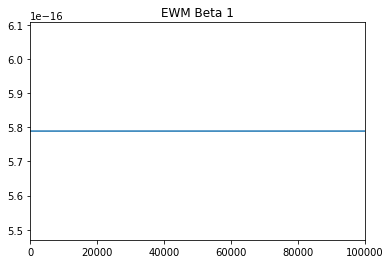

In [128]:
df5['beta1_t'].plot()
plt.title('EWM Beta 1')

The beta is constant over this time because the returns are constant over this time. This is a result of using forward-fill, which results many rows of identical values. The betas did not change over this time frame. I used this limited time frame (the first 10% of data) because computing betas for the full 1M rows would take too long. The code took a long time to run.

Text(0.5, 1.0, 'EWM correlation over time')

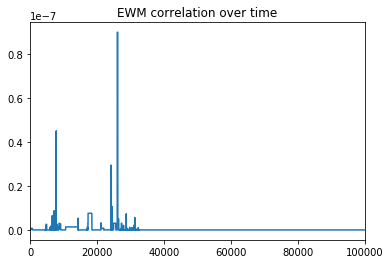

In [127]:
df5['corr1_t'].plot()
plt.title('EWM correlation over time')

The correlation does show some variation over time.